In [5]:
from func_auxiliares.config import DB_PATH
import sqlite3
from func_auxiliares.graficos_utils import get_df
df = get_df("select año, exportaciones from balanza_comercial", str(DB_PATH))
df

,exportaciones
año,
1949,102.97
1950,94.07
1951,150.59
1952,141.30
1953,112.66
...,...
2020,7092.60
2021,11259.50
2022,13924.20


Resultados ADF/KPSS (objetivo: ADF_p<0.05 y KPSS_p>=0.05):
    n  ADF_stat   ADF_p  KPSS_stat  KPSS_p
d                                         
0  76    3.5339  1.0000     1.0036    0.01
1  75   -7.1617  0.0000     0.1352    0.10
2  74   -0.6696  0.8545     0.1630    0.10


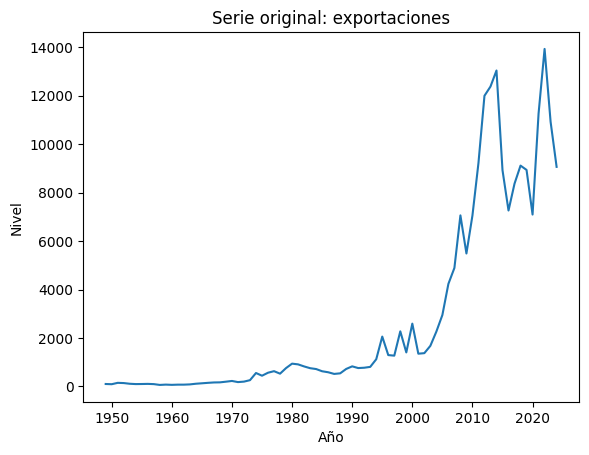

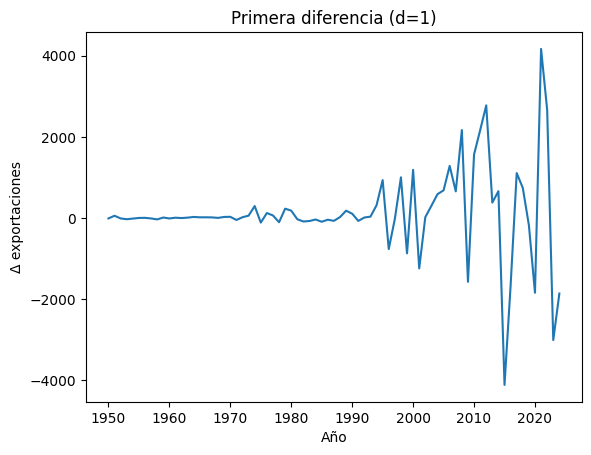

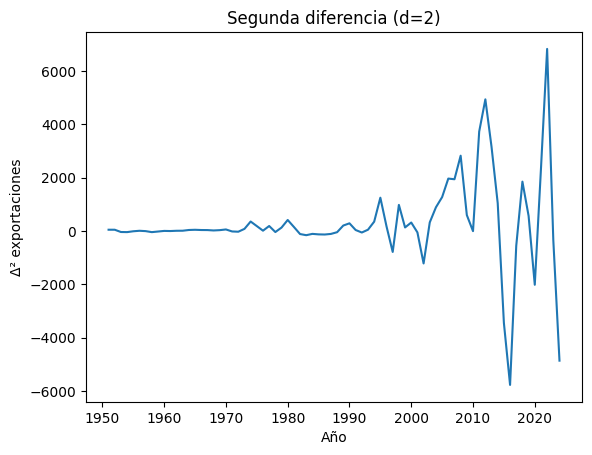

<Figure size 640x480 with 0 Axes>

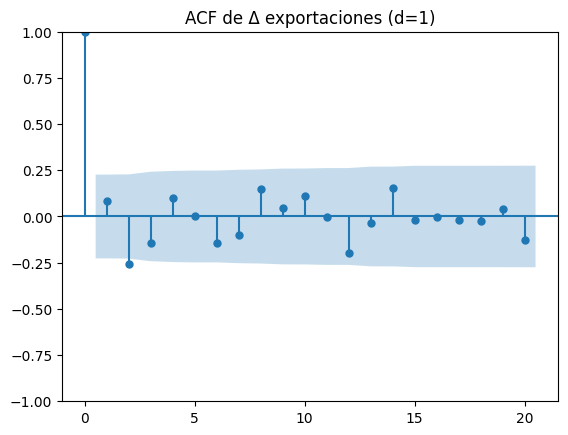

<Figure size 640x480 with 0 Axes>

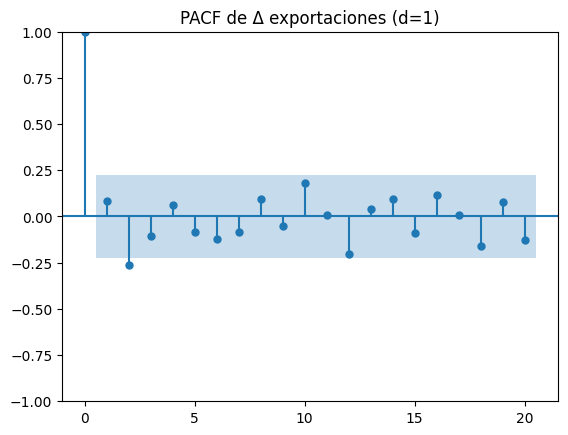

<Figure size 640x480 with 0 Axes>

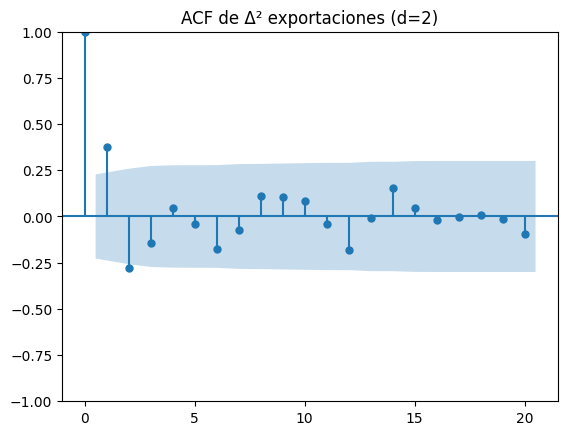

<Figure size 640x480 with 0 Axes>

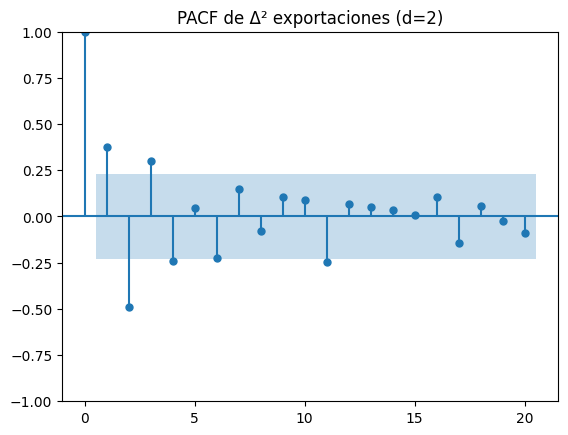


→ Conclusión: d=1 cumple estacionariedad (ADF_p<0.05 y KPSS_p>=0.05).


In [11]:
# === Estacionarizar por diferenciación y verificar ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 0) Serie
y = df["exportaciones"].astype(float).copy()
y.name = "exportaciones"

def adf_kpss(series):
    series = series.dropna()
    # ADF (H0: raíz unitaria -> NO estacionaria)
    adf_stat, adf_p, *_ = adfuller(series, autolag="AIC")
    # KPSS (H0: estacionaria en nivel)
    # Para series diferenciadas usamos 'c'; si fallara, cambiar a regression="ct".
    kpss_stat, kpss_p, *_ = kpss(series, regression="c", nlags="auto")
    return adf_stat, adf_p, kpss_stat, kpss_p, len(series)

# 1) Diferenciaciones
y_d0 = y.copy()
y_d1 = y.diff().dropna()
y_d2 = y.diff(2).dropna()

# 2) Tabla de resultados (ADF y KPSS)
rows = []
for d, s in [(0, y_d0), (1, y_d1), (2, y_d2)]:
    try:
        adf_stat, adf_p, kpss_stat, kpss_p, n = adf_kpss(s)
    except Exception as e:
        adf_stat=adf_p=kpss_stat=kpss_p=np.nan; n=len(s)
    rows.append({
        "d": d, "n": n,
        "ADF_stat": adf_stat, "ADF_p": adf_p,
        "KPSS_stat": kpss_stat, "KPSS_p": kpss_p
    })

tabla = pd.DataFrame(rows).set_index("d").round(4)
print("Resultados ADF/KPSS (objetivo: ADF_p<0.05 y KPSS_p>=0.05):")
print(tabla)

# 3) Gráficas de series (una por figura)
plt.figure()
y.plot()
plt.title("Serie original: exportaciones")
plt.xlabel("Año"); plt.ylabel("Nivel")

plt.figure()
y_d1.plot()
plt.title("Primera diferencia (d=1)")
plt.xlabel("Año"); plt.ylabel("Δ exportaciones")

plt.figure()
y_d2.plot()
plt.title("Segunda diferencia (d=2)")
plt.xlabel("Año"); plt.ylabel("Δ² exportaciones")

# 4) ACF/PACF para d=1 (y también d=2 para comparar)
max_lags = min(20, len(y_d1)-2) if len(y_d1) > 5 else 10

plt.figure()
plot_acf(y_d1, lags=max_lags)
plt.title("ACF de Δ exportaciones (d=1)")

plt.figure()
plot_pacf(y_d1, lags=max_lags, method="ywm")
plt.title("PACF de Δ exportaciones (d=1)")

if len(y_d2) > 5:
    max_lags2 = min(20, len(y_d2)-2)
    plt.figure()
    plot_acf(y_d2, lags=max_lags2)
    plt.title("ACF de Δ² exportaciones (d=2)")

    plt.figure()
    plot_pacf(y_d2, lags=max_lags2, method="ywm")
    plt.title("PACF de Δ² exportaciones (d=2)")

plt.show()

# 5) Regla de decisión rápida
def es_estacionaria(row, alpha=0.05):
    return (row["ADF_p"] < alpha) and (row["KPSS_p"] >= alpha)

candidatos = [d for d in tabla.index if es_estacionaria(tabla.loc[d])]
if candidatos:
    d_sel = candidatos[0]
    print(f"\n→ Conclusión: d={d_sel} cumple estacionariedad (ADF_p<0.05 y KPSS_p>=0.05).")
else:
    # Señala el mejor candidato aproximado (menor ADF_p y menor KPSS_stat)
    tmp = tabla.assign(score = tabla["ADF_p"].rank(method="dense") +
                                 tabla["KPSS_stat"].rank(method="dense"))
    d_sel = int(tmp.sort_values("score").index[0])
    print(f"\n→ Ningún d cumple ambos criterios estrictos. "
          f"Sugerencia inicial: d={d_sel} (mejor compromiso).")

# 6) (Opcional) añade columnas al df para inspección o guardar
df["exp_diff1"] = y.diff()
df["exp_diff2"] = y.diff(2)


Mejor ARIMA(2,1,3) trend='n'  AIC=1202.78
                               SARIMAX Results                                
Dep. Variable:          exportaciones   No. Observations:                   76
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -595.390
Date:                Thu, 14 Aug 2025   AIC                           1202.780
Time:                        16:59:18   BIC                           1216.357
Sample:                             0   HQIC                          1208.179
                                 - 76                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4143      0.081      5.117      0.000       0.256       0.573
ar.L2         -1.1373      0.090    -12.573      0.000      -1.315      -0.960
ma.L1     

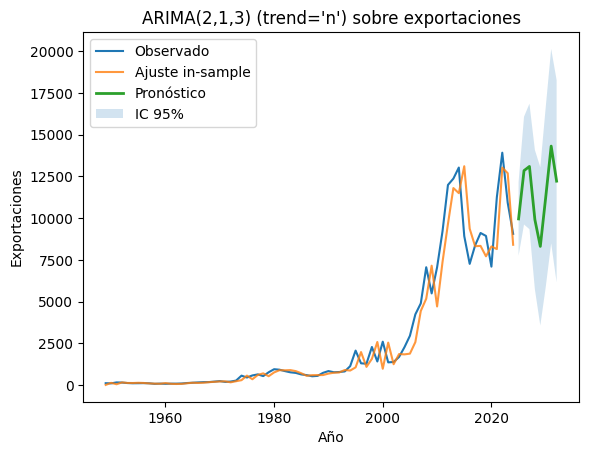

In [16]:
# === ARIMA(p,1,q) sobre exportaciones (anual) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 0) Serie
if "año" in df.columns:
    df = df.set_index("año")
df = df.sort_index()
y = df["exportaciones"].astype(float)
y.name = "exportaciones"

# 1) Búsqueda simple de (p,q) por AIC (d=1). Probar con y sin drift.
cands = []
for p in range(0, 4):
    for q in range(0, 4):
        for trend in ["n", "c"]:  # sin drift / con drift
            try:
                mod = SARIMAX(y, order=(p,1,q), trend=trend,
                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                cands.append((mod.aic, (p,q,trend), mod))
            except Exception:
                pass

aic, (p,q,trend), res = min(cands, key=lambda z: z[0])
print(f"Mejor ARIMA({p},1,{q}) trend='{trend}'  AIC={aic:.2f}")
print(res.summary())

# 2) Ajuste in-sample y residuos
df["arima_fit"] = res.fittedvalues  # niveles (statsmodels integra d=1 internamente)
df["arima_resid"] = y - df["arima_fit"]

# 3) Pronóstico h pasos
h = 8  # cambia si quieres más/menos años
fc = res.get_forecast(steps=h)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

# 4) Índice de pronóstico (años)
last_year = int(y.index[-1])
fc_index = pd.Index(range(last_year+1, last_year+h+1), name="año")
fc_mean.index = fc_index
fc_ci.index = fc_index

# 5) Graficar nivel + ajuste + pronóstico
plt.figure()
y.plot(label="Observado", linewidth=1.5)
df["arima_fit"].plot(label="Ajuste in-sample", alpha=0.8)
fc_mean.plot(label="Pronóstico", linewidth=2)

# bandas
plt.fill_between(fc_ci.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], alpha=0.2, label="IC 95%")

plt.title(f"ARIMA({p},1,{q}) (trend='{trend}') sobre exportaciones")
plt.xlabel("Año"); plt.ylabel("Exportaciones")
plt.legend(); plt.show()

# 6) (Opcional) guardar objetos útiles
resultados = {
    "orden": (p,1,q),
    "trend": trend,
    "aic": aic,
    "fitted": df["arima_fit"],
    "residuos": df["arima_resid"],
    "forecast_mean": fc_mean,
    "forecast_ci": fc_ci
}




In [19]:
fc_mean

año
2025     9954.880241
2026    12850.125049
2027    13100.873386
2028     9912.126468
2029     8305.859276
2030    11266.799639
2031    14320.257165
2032    12217.963989
Name: predicted_mean, dtype: float64

In [24]:
df[['exportaciones']].tail(11)

,exportaciones
año,
2014,13034.2
2015,8923.1
2016,7258.7
2017,8367.1
2018,9110.4
2019,8933.3
2020,7092.6
2021,11259.5
2022,13924.2
